In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
!pip install git+https://github.com/nottombrown/imagenet_stubs --upgrade

In [ ]:
!pip install --user tensorflow-addons==0.8.3
#!pip install --user tensorflow==2.2.0-rc3

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

In [42]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 50.
max_iter = 100

Model

In [11]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values)

In [9]:
#keras Tutorial: Using a pre-trained ImageNet
import numpy as np
# import the models for further classification experiments
from tensorflow.keras.applications import (
        vgg16,
        resnet50,
        mobilenet,
        inception_v3
    )
resnet_model = resnet50.ResNet50(weights='imagenet')
image_batch = np.expand_dims(images, axis=0)
#processed_images=image_batch
processed_images = resnet50.preprocess_input(image_batch.copy())

In [ ]:
tfc.predict(processed_images[0])

ImageNet Training

In [5]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [6]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

In [13]:
predictions = tfc.predict(processed_images[0])
label = decode_predictions(predictions)
# print VGG16 predictions
for prediction_id in range(len(label[0])):
    print(label[0][prediction_id])

('n02113799', 'standard_poodle', 0.5366574)
('n02113712', 'miniature_poodle', 0.27960038)
('n02099429', 'curly-coated_retriever', 0.09928669)
('n02102973', 'Irish_water_spaniel', 0.054727875)
('n02099849', 'Chesapeake_Bay_retriever', 0.011090273)


In [14]:
processed_images=processed_images.reshape(16, 224, 224, 3)

Patch_gen

In [43]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))
patch, patch_mask = ap.generate(x=processed_images, y=y_target)


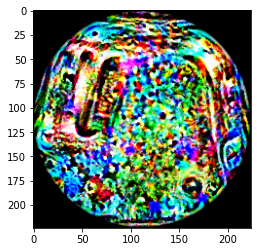

In [44]:
#Adversarial Patch
plt.imshow(((patch) * patch_mask).astype(np.uint8))

In [45]:
patched_images = ap.apply_patch(processed_images, scale=0.5)

In [ ]:
!pip install tensorflow-addons

In [28]:
def predict_model(classifier, image):
    plt.imshow((image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    #print("error1")
    prediction = classifier.predict(image)
    #print("error2")
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

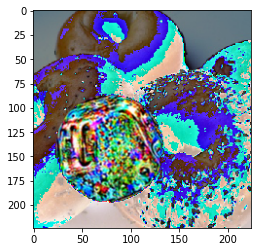

Predictions:
toaster    0.96
chain      0.01
bagel      0.01
piggy_bank 0.00
padlock    0.00


In [49]:
predict_model(tfc, patched_images[2])